In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
desk = pd.read_csv("desktop.csv")
mobile = pd.read_csv("mobile.csv")

In [3]:
# convert cdn to boolean values for simplicity
desk['cdn'] = 1- desk['cdn'].isna()
mobile['cdn'] = 1- mobile['cdn'].isna()

supprimer les donnees qui dis rien

In [4]:
# desk = desk.drop("metadata",axis=1)
# createDate timestampe
# archive, all value are 'all'
# label, date
# crawlid all value are 1
# wptid
# wptrun all value are 1
# startedDateTime from 5.4 to 11.4
# doctype string values...
# meta_viewport


useless = ['pageid','createDate','archive','label','crawlid','wptid','wptrun','url','urlShort','urlhash', 'startedDateTime','doctype', 'meta_viewport',"metadata"]
desk = desk.drop(useless, axis=1)
mobile = mobile.drop(useless, axis=1)

supprimer les donnee identique

In [11]:
# all_same = []
# for c in desk.columns:
#     if len(set(desk[c])) ==1:
#         all_same.append(c)
# desk = desk.drop(all_same, axis=1)

supprimer les donnee Nan

In [5]:
all_na =  desk.isna().all(axis=0)
all_na = desk.columns[np.where(all_na)]
print("delete: ", all_na)
desk = desk.drop(all_na, axis=1)
mobile = mobile.drop(all_na, axis=1)

delete:  Index(['PageSpeed'], dtype='object')


In [6]:
desk = desk.fillna(desk.mean())
mobile = mobile.fillna(mobile.mean())

In [7]:
desk['type'] = 'desk'
mobile['type'] = 'mobile'

## req analyze

In [15]:
req_clos = []
for c in desk.columns:
    if str(c).startswith('req'):
        req_clos.append(c)

In [16]:
req_clos.remove('reqTotal')
req_clos.remove('reqImg')

In [17]:
req_desk = desk.loc[:, req_clos]
req_mob = mobile.loc[:, req_clos]


In [18]:
req_desk["type"] = 'desk'
req_mob["type"] = 'mob'

In [19]:
req_df = pd.concat([req_mob, req_desk],ignore_index=True)

In [20]:
from sklearn.decomposition import PCA

In [21]:
X = req_df.iloc[:,:-1]
X

reqHtml  reqJS  reqCSS  reqGif  reqJpg  reqPng  reqFont  reqOther  \
0           1      0       0       0       0       0        0         0   
1           1      0       0       0       0       0        0         0   
2           1      0       0       0       0       0        0         0   
3           0      0       0       0       0       0        0         1   
4           1      0       0       0       0       0        0         0   
...       ...    ...     ...     ...     ...     ...      ...       ...   
1995        1      1       1       0       3       2        0         0   
1996        1      4       1       0       1       1        0         0   
1997        2      0       1       4       1       0        0         0   
1998        1      2       3       0       0       2        1         0   
1999        1      1       0       0       1       0        5         0   

      reqAudio  reqText  reqXml  reqWebp  reqSvg  
0            0        0       0        0       0  
1            0        0       0        0       0  
2            0        0       0        0       0  
3            0        0       0        0       0  
4            0        0       0        0       0  
...        ...      ...     ...      ...     ...  
1995         0        0       0        0       0  
1996         0        0       0        0       0  
1997         0        0       0        0       0  
1998         0        0       0        0       0  
1999         0        0       0        0       1  

[2000 rows x 13 columns]

In [22]:
X.loc[1689,:]

reqHtml       1
reqJS         0
reqCSS        0
reqGif        0
reqJpg      259
reqPng        0
reqFont       0
reqOther      0
reqAudio      0
reqText       0
reqXml        0
reqWebp       0
reqSvg        0
Name: 1689, dtype: int64

In [24]:
cls = PCA(n_components=(X.shape[1]))
pca = cls.fit_transform(X.to_numpy())
# sns.scatterplot(x=range(16), y=cls.explained_variance_ratio_)

<Axes: >

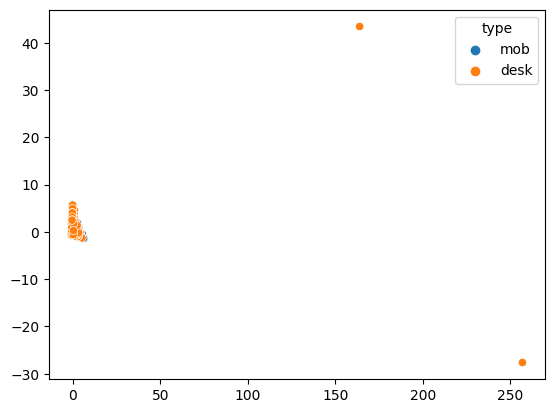

In [ ]:
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=req_df['type'])

In [ ]:
indices = np.where(pca[:,0] >50)[0]
indices

array([1508, 1689])

In [ ]:
X.loc[indices]

reqHtml  reqJS  reqCSS  reqGif  reqJpg  reqPng  reqFont  reqFlash   
1508        1     25       4       3     159      55       10         0  \
1689        1      0       0       0     259       0        0         0   

      reqJson  reqOther  reqAudio  reqVideo  reqText  reqXml  reqWebp  reqSvg  
1508        0         1         0         0        0       0        0       0  
1689        0         0         0         0        0       0        0       0

In [ ]:
req_df = req_df.drop(indices)
X = X.drop(indices)

In [ ]:
pca = cls.fit_transform(X.to_numpy())

<BarContainer object of 16 artists>

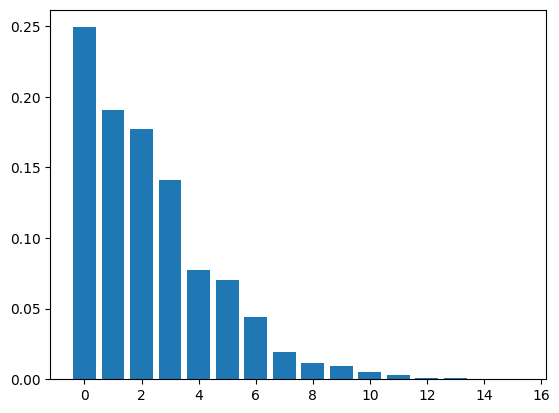

In [ ]:
cls.explained_variance_ratio_
plt.bar(range(16), cls.explained_variance_ratio_)

<BarContainer object of 16 artists>

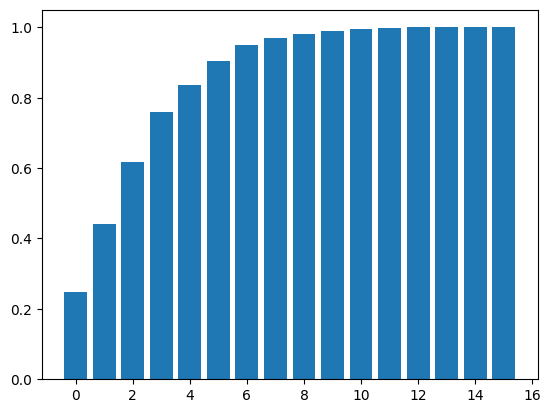

In [ ]:
plt.bar(range(16), [sum(cls.explained_variance_ratio_[:i]) for i in range(1,17)])


<Axes: >

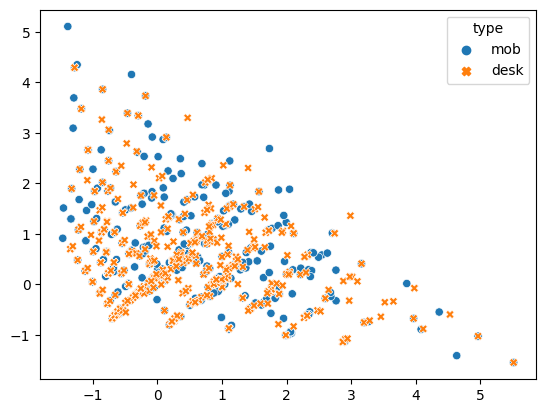

In [ ]:
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=req_df['type'], style=req_df['type'])

# classification of desktop and mobile

## logistic

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [9]:
df = pd.concat([desk, mobile],ignore_index=True)

In [119]:
df = df.drop(['document_width'],axis=1)

In [10]:
X = df.iloc[:,:-1]
y = df.loc[:,'type']
# X = X.to_numpy()
# y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=39)


In [161]:
X_train.columns

Index(['cdn', 'TTFB', 'renderStart', 'onContentLoaded', 'onLoad',
       'fullyLoaded', 'visualComplete', 'SpeedIndex', 'rank', 'reqTotal',
       'reqHtml', 'reqJS', 'reqCSS', 'reqImg', 'reqGif', 'reqJpg', 'reqPng',
       'reqFont', 'reqFlash', 'reqJson', 'reqOther', 'bytesTotal', 'bytesHtml',
       'bytesJS', 'bytesCSS', 'bytesImg', 'bytesGif', 'bytesJpg', 'bytesPng',
       'bytesFont', 'bytesFlash', 'bytesJson', 'bytesOther', 'bytesHtmlDoc',
       'numDomains', 'maxDomainReqs', 'numRedirects', 'numErrors', 'numGlibs',
       'numHttps', 'numCompressed', 'numDomElements', 'maxageNull', 'maxage0',
       'maxage1', 'maxage30', 'maxage365', 'maxageMore', 'gzipTotal',
       'gzipSavings', '_connections', '_adult_site', 'avg_dom_depth',
       'document_height', 'document_width', 'localstorage_size',
       'sessionstorage_size', 'num_iframes', 'num_scripts', 'reqAudio',
       'reqVideo', 'reqText', 'reqXml', 'reqWebp', 'reqSvg', 'bytesAudio',
       'bytesVideo', 'bytesText', 'byt

In [22]:
mod = LogisticRegression(penalty=None, max_iter=3000, solver='newton-cg')
mod.fit(X_train, y_train)
(mod.predict(X_test) == y_test).mean()

/usr/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dani/.local/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


0.9742424242424242

In [12]:
mod = LogisticRegression(penalty=None, max_iter=3000)
mod.fit(X_train, y_train)
(mod.predict(X_test) == y_test).mean()

/home/dani/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8166666666666667

In [ ]:
train_accr = []
test_accr = []
dx =  np.linspace(100, 8000, 200)
for i in dx:
    mod = LogisticRegression(penalty=None, max_iter=int(i))
    mod.fit(X_train, y_train)
    train_accr.append((mod.predict(X_train) == y_train).mean())
    test_accr.append((mod.predict(X_test) == y_test).mean())

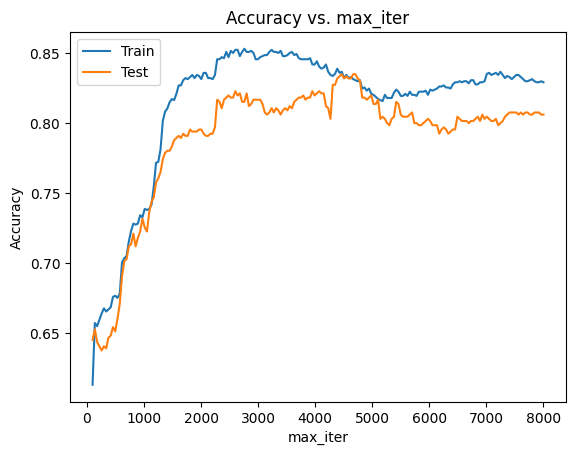

In [34]:
plt.plot(dx, train_accr)
plt.plot(dx, test_accr)

# plt.text(dx[-1], train_accr[-1], 'Train Accuracy', color='blue', fontsize=12)
# plt.text(dx[-1], test_accr[-1], 'Test Accuracy', color='orange', fontsize=12)

plt.xlabel('max_iter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_iter')
plt.legend(['Train', 'Test'])
plt.show()



### scaling before fitting

In [76]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline

In [100]:
scaler = preprocessing.StandardScaler()
mod = LogisticRegression(penalty=None,max_iter=5000, solver='newton-cg')
pipe = make_pipeline(scaler, mod)

In [93]:
pipe.fit(X_train, y_train)
(pipe.predict(X_test) == y_test).mean(), (pipe.predict(X_train) == y_train).mean()

(0.9833333333333333, 0.9917910447761195)

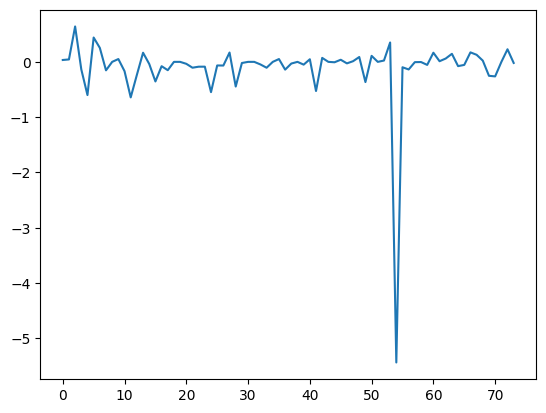

In [94]:
plt.plot(list(range(mod.coef_.shape[1])),mod.coef_[0,:])

select coef significant

In [95]:
coef = mod.coef_[0,:]
mask = np.abs(coef) > 5
mask = np.append(mask, False)
df.columns[mask]

Index(['document_width'], dtype='object')

In [195]:
x_t = scaler.transform(X_train)

In [59]:
ddf = df.copy()
X = ddf.loc[:, ('document_width', 'document_height')].to_numpy()
# X += 1
# X = np.log(X)
# X = preprocessing.StandardScaler().fit_transform(X)

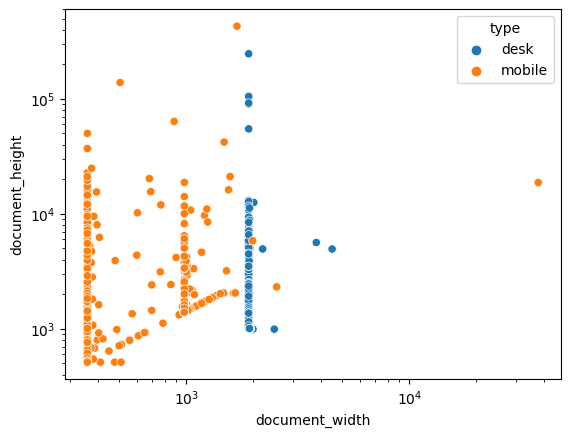

In [69]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=df['type'])
plt.xlabel('document_width')
plt.ylabel('document_height')
plt.xscale('log')
plt.yscale('log')

In [96]:
dx = np.linspace(1000,2000,1000)
res = []
for i in dx:
    res.append(((X_test.loc[:,'document_width'] >=i) == (y_test== 'desk')).mean())
max(res)


0.9954545454545455

In [101]:
((X_test.loc[:,'document_width'] >=1900) == (y_test== 'desk')).mean()

0.9954545454545455

### test de wald

In [96]:
def Wald_test_LR(model, X):
    prob = model.predict_proba(X)
    What = np.diag(np.product(prob, axis=1))
    In_F = X.T @ What @ X
    shat = np.sqrt(np.diag(np.linalg.inv(In_F)))
    zscores = model.coef_ / shat
    nonsign = np.abs(zscores) <= spst.norm.ppf(1 - 0.05 / 2, loc=0, scale=1)
    return zscores, nonsign

Wald_test_LR(mod, scaler.transform(X_train))

LinAlgError: Singular matrix

### test de vraisemblance

In [14]:
from sklearn.metrics import log_loss
from scipy import stats as spst
import copy as cp

In [15]:
def loglike_LR(model, X, y):
    targ = np.column_stack((1 - y, y))
    prob = model.predict_proba(X)
    return -log_loss(targ, prob, normalize=False)

In [40]:
X_ = cp.copy(X)
y_ = y == 'mobile'
pipe.fit(X_, y)
ll_ = loglike_LR(pipe, X_, y_)
ll = ll_
while 2 * (ll - ll_) <= spst.chi2.ppf(1 - 0.05, 1):
    Xopt = cp.copy(X_)
    clsopt = cp.copy(pipe)
    llopt = cp.copy(ll_)
    lltab = np.zeros(Xopt.shape[1])
    for i in range(Xopt.shape[1]):
        X_ = cp.copy(Xopt)
        X_.drop(columns=X_.columns[i], inplace=True)
        pipe.fit(X_, y)
        lltab[i] = loglike_LR(pipe, X_, y_)
    X_ = cp.copy(Xopt)
    X_.drop(columns=X_.columns[lltab.argmax()], inplace=True)
    pipe.fit(X_, y)
    ll_ = loglike_LR(pipe, X_, y_)

In [45]:
clsopt.named_steps['logisticregression'].coef_.mean(), pipe.named_steps['logisticregression'].coef_.mean()

(-0.26139607183256125, -0.08537586435823502)

In [42]:
Xopt.columns

Index(['TTFB', 'renderStart', 'onContentLoaded', 'onLoad', 'reqHtml', 'reqJS',
       'reqOther', 'bytesHtml', 'bytesCSS', 'numDomElements', '_connections',
       'document_height', 'document_width'],
      dtype='object')

#### inverse order

In [67]:

X_ = pd.DataFrame()
y_ = y == 'mobile'

targ = np.column_stack((1 - y_, y_))
prob = np.random.choice(2, y.shape[0])
ll = -log_loss(targ, prob, normalize=False)

col_opt = []
cols = X.columns.to_numpy()
ll_history = []
while True:
# while 
    Xopt = cp.copy(X_)
    lltab = np.zeros(cols.shape[0])
    for i,col in enumerate(cols):
        X_ = cp.copy(Xopt)
        X_[col] = X[col]
        pipe.fit(X_, y)
        lltab[i] = loglike_LR(pipe, X_, y_)
    X_ = cp.copy(Xopt)

    col = cols[lltab.argmax()]
    # print(col)
    cols = np.delete(cols,lltab.argmax())
    X_[col] = X[col]
    pipe.fit(X_, y)
    ll_ = loglike_LR(pipe, X_, y_)
    if 2 * (ll_ -ll) <= spst.chi2.ppf(1 - 0.05, 1):
        break
    ll = ll_
    ll_history.append(ll)
    col_opt.append(col)


In [73]:
X_ = cp.copy(X)
y_ = y == 'mobile'
pipe.fit(X_, y)
ll_ = loglike_LR(pipe, X_, y_)
# ll_history.append(ll_)
col_opt.append('all')

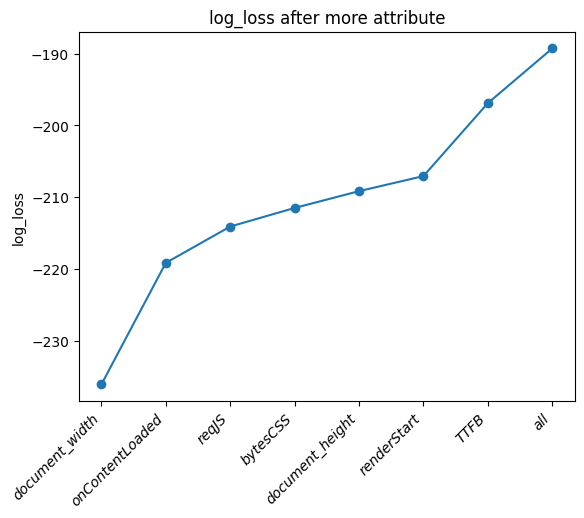

In [75]:
plt.plot(col_opt, ll_history, marker='o')
plt.ylabel("log_loss")
plt.title("log_loss after more attribute")
_ = plt.xticks(col_opt, rotation=45, ha='right', fontstyle='italic')

In [107]:
Xopt = pd.DataFrame()
y_ = y == 'mobile'
col_opt = []
cols = X.columns.to_numpy()
ll_history = []

lltab = np.zeros(cols.shape[0])
for i,col in enumerate(cols):
    X_ = cp.copy(Xopt)
    X_[col] = X[col]
    pipe.fit(X_, y)
    lltab[i] = loglike_LR(pipe, X_, y_)


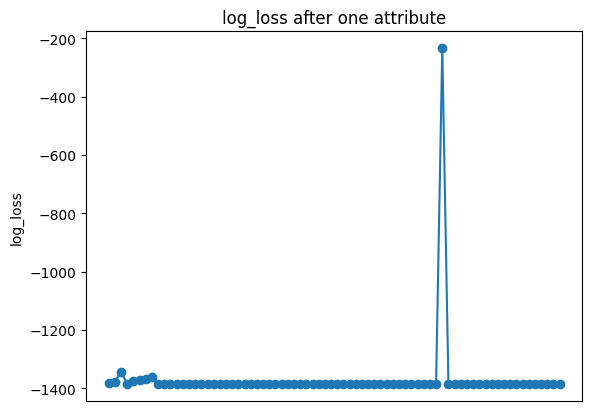

In [118]:
plt.plot(cols, lltab, marker='o')
plt.ylabel("log_loss")
plt.title("log_loss after one attribute")
# plt.yscale('log')
_ = plt.xticks(col_opt, rotation=90, ha='right', fontstyle='italic')

## random forest

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [120]:
rf = RandomForestClassifier()
tree = DecisionTreeClassifier()

In [121]:
rf.fit(X_train, y_train)
(rf.predict(X_test) == y_test).mean(), (rf.predict(X_train) == y_train).mean()

(0.9954545454545455, 1.0)